# Анализ убытков приложения ProcrastinatePRO+

Развлекательное приложение Procrastinate Pro+, несмотря на огромные вложения в рекламу, последние несколько месяцев терпит убытки. Необходимо разобраться в причинах и помочь компании выйти в плюс.  

В нашем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года: лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы. Изучим, откуда приходят пользователи и какими устройствами они пользуются, сколько стоит привлечение пользователей из различных рекламных каналов, сколько денег приносит каждый клиент, когда расходы на привлечение клиента окупаются, какие факторы мешают привлечению клиентов.

**Цель проекта**  
Выявить причины убытков приложения Procrastinate Pro+ за последние несколько месяцев. 

**Описание данных**  

Структура `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта:
* `User Id` — уникальный идентификатор пользователя
* `Region` — страна пользователя
* `Device` — тип устройства пользователя
* `Channel` — идентификатор источника перехода
* `Session Start` — дата и время начала сессии
* `Session End` — дата и время окончания сессии

Структура `orders_info_short.csv` хранит информацию о заказах:
* `User Id` — уникальный идентификатор пользователя
* `Event Dt` — дата и время покупки
* `Revenue` — сумма заказа

Структура `costs_info_short.csv` хранит информацию о расходах на рекламу:
* `dt` — оценка пользователей (максимум 10)
* `Channel` — идентификатор рекламного источника
* `costs` — расходы на эту кампанию


**Оглавление**

1. [Изучение общей информации и подготовка данных к анализу](#start) 
    * [Общая информация](#info)
    * [Предобоработка данных](#pre)
2. [Функции для расчёта и анализа LTV, ROI, удержания и конверсии](#func)
    * [Функция для создания профилей пользователей](#profile)
    * [Функция для подсчёта Retention Rate](#rr)
    * [Функция для подсчёта конверсии](#cr)
    * [Функция для подсчёта LTV и ROI](#ltv)
    * [Функция для  сглаживания данных](#filter)
    * [Функция для построения графика Retention Rate](#rr_plot)
    * [Функция для построения графика конверсии](#cr_plot)
    * [Функция для визуализации LTV и ROI](#ltv_plot)
3. [Исследовательский анализ данных](#research) 
    * [Профили пользователей](#users)
    * [Анализ распределения пользователей с разбивкой по странам](#users_contry)
    * [Анализ распределения пользователей с разбивкой по устройствам](#users_device)
    * [Анализ распределения пользователей с разбивкой по каналам привлечения](#users_channel)
4. [Маркетинг](#mark) 
    * [Распределение расходов на рекламу по источникам](#mark)
    * [Динамика изменения расходов по каждому источнику по неделям и месяцам](#cost)
    * [Средняя стоимость привлечения одного пользователя (CAC) из каждого источника](#cac)
5. [Оценка окупаемости рекламы](#eva) 
    * [Общая окупаемость рекламы](#ad)
    * [Окупаемость рекламы с разбивкой по устройствам](#device)
    * [Окупаемость рекламы с разбивкой по странам](#country)
    * [Окупаемость рекламы с разбивкой по каналам привлечения](#channel)
6. [Общий вывод](#rec) 

<a id="start"></a>

## Изучение общей информации и подготовка данных к анализу

Загружаем данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
# загруженние данных
path = '/datasets/'
visits, orders, costs = (
        pd.read_csv(path + 'visits_info_short.csv'), # журнал сессий
        pd.read_csv(path + 'orders_info_short.csv'), # покупки
        pd.read_csv(path + 'costs_info_short.csv') # траты на рекламу
)

<a id="info"></a>

### Общая информация

In [3]:
# напишем функцию для полного описания данных
def total_describe(data):
    data_head = data.head(5)
    data_info = data.info()
    data_isna = pd.DataFrame(data.isna().sum())
    data_isna.columns = ['count_miss']
    print(data_info)
    print('Первые пять строк таблицы:')
    display(data_head)
    print('Информация о пропусках в данных:')
    display(data_isna)

* **О таблице visits**

In [4]:
# выведем всю информацию о таблице
total_describe(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
Первые пять строк таблицы:


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Информация о пропусках в данных:


,count_miss
User Id,0
Region,0
Device,0
Channel,0
Session Start,0
Session End,0


**Вывод:**  
Файл содержит лог сервера с информацией о посещениях сайта.  
Всего в датасете 309901 запись и 6 столбцов.  
* Пропуски отсутсвуют
* Некорекктно записаны наименования всех столбцов
* Столбцы `Session Start` и `Session End` имеют некорректный тип данных

* **О таблице orders**

In [5]:
# выведем всю информацию о таблице
total_describe(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
Первые пять строк таблицы:


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Информация о пропусках в данных:


,count_miss
User Id,0
Event Dt,0
Revenue,0


**Вывод:**  
Файл содержит лог сервера с информацией о заказах.  
Всего в датасете 40212 запись и 3 столбца.  
* Пропуски отсутсвуют
* Некорекктно записаны наименования всех столбцов
* Столбец `Event Dt` имеет некорректный тип данных

* **О таблице costs**

In [6]:
# выведем всю информацию о таблице
total_describe(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
Первые пять строк таблицы:


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Информация о пропусках в данных:


,count_miss
dt,0
Channel,0
costs,0


**Вывод:**  
Файл содержит лог сервера с информацией о тратах на рекламу.  
Всего в датасете 1800 запись и 3 столбца.  
* Пропуски отсутсвуют
* Некорекктно записано наименование столбца `Channel`
* Столбец `dt` нужно привести к формату даты

**Вывод по трем датасетам**

<div class="alert alert-info">   
Необходимо:   

* Переименовать столбцы, где используется верхний регистр и отсутствует стиль snake case
* Изменить тип данных в столбцах с времнем на datetime
* Также проверить данные на явные и неявные дубликаты
     </div>

<a id="pre"></a>

### Предобработка данных

**Переименования столбцов**

In [7]:
# список датасетов
datasets = [visits, orders, costs]

# приведем названия столбцов к нижнему регистру, заменим пробелы на нижнее подчеркивание и выведем результат списоком
for data in datasets:
    data.columns = [col.lower().replace(' ', '_') for col in data.columns]
    print(data.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


**Изменение типа данных**

In [8]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Обработка дубликатов**

Проверим наличие явных строк-дубликатов.

In [9]:
# посчитаем количество строк-дубликатов
for data in datasets:
    print(f'Количество строк дубликатов: {data.duplicated().sum()}')

Количество строк дубликатов: 0
Количество строк дубликатов: 0
Количество строк дубликатов: 0


**Вывод**

<div class="alert alert-info">   
В результате предобработки данных: 

* перевели все наименования столбцов в нижний регистр и переименовали;  
* не было обнаружено явных строк-дублиикатов;  
* изменили тип данных в `session_start`, `session_end`, `event_dt`, `dt` на datetime. Столбец `dt` был переведен обратно для дальнейшей с ним работы.
     </div>

<a id="func"></a>

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

<a id="profile"></a>

### Функция для создания профилей пользователей

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

<a id="rr"></a>

### Функция для подсчёта Retention Rate

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


<a id="cr"></a>

### Функция для подсчёта конверсии

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

<a id="ltv"></a>

### Функция для подсчёта LTV и ROI

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

<a id="filter"></a>

### Функция для  сглаживания данных

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

<a id="rr_plot"></a>

### Функция для построения графика Retention Rate

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

<a id="cr_plot"></a>

### Функция для построения графика конверсии

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

<a id="ltv_plot"></a>

### Функция для визуализации LTV и ROI

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных
<a id="research"></a>

<a id="users"></a>

### Профили пользователей  
Составим профили пользователей с помощью ранее введенной функции `get_profiles()`.

In [18]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную даты привлечения пользователей.

In [19]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print(f'Минимальная дата привлечения пользователей: {min_date}')
print(f'Максимальная дата привлечения пользователей: {max_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года соответствуют условиям проекта.

<a id="users_country"></a>

### Анализ распределения пользователей с разбивкой по странам   
Создадим функцию, которая будет выводить таблицу распредления пользователей по дополнительным признакам.

In [20]:
def profiles_columns(column):
    
    # сгруппируем данные по доплнительному признаку 
    # и посчитаем количество уникальных пользователей, количество и долю платящих
    profiles_grouped = profiles.groupby(column).agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
    
    # переименуем столбцы
    profiles_grouped.columns = ['count_users', 'payer_sum', 'payer_perc']
    
    # переведем доли в проценты
    profiles_grouped['payer_perc'] = round(profiles_grouped['payer_perc'] * 100, 2)
    
    # выведем результат, сортируя количество уникальных пользователей по убыванию
    return profiles_grouped.sort_values(by='count_users', ascending=False)

Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [21]:
profiles_columns('region')

,count_users,payer_sum,payer_perc
region,,,
United States,100002,6902,6.90
UK,17575,700,3.98
France,17450,663,3.80
Germany,14981,616,4.11


Пользователи приходят в приложение из США, Украины, Франции и Германии. Причем наибольшее количество пользователей приходят из США. Остальное количество пользователей распределено среди других стран практически поровну.  
Также самая высокая доля платящих находится тоже в США - 6,9%. Доля платящих в других странах составляет примерно 4%.

<a id="users_device"></a>

### Анализ распределения пользователей с разбивкой по устройствам  
Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [22]:
profiles_columns('device')

,count_users,payer_sum,payer_perc
device,,,
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05
Mac,30042,1912,6.36


Большая часть пользователей переходят в приложение через iPhone, остальная часть пользователей использует Android, PC и Mac.   
Однако высокая доля платящих клиентов приходится на пользователей Mac - 6,36 и следом за ним уже iPhone - 6,21.

<a id="users_channel"></a>

### Анализ распределения пользователей с разбивкой по каналам привлечения 
Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [23]:
profiles_columns('channel')

,count_users,payer_sum,payer_perc
channel,,,
organic,56439,1160,2.06
FaceBoom,29144,3557,12.20
TipTop,19561,1878,9.60
OppleCreativeMedia,8605,233,2.71
LeapBob,8553,262,3.06
WahooNetBanner,8553,453,5.30
RocketSuperAds,4448,352,7.91
MediaTornado,4364,156,3.57
YRabbit,4312,165,3.83


Основная часть приходит в приложение самостоятельно (organic), без рекламы, но у таких пользователей самая минимальная доля платящих. Среди рекламных площадок значительное количество пользователей переходят в приложение через FaceBoom и TipTop.  
Лидирующие позиции по доле платящих пользователей занимают такие каналы, как FaceBoom (12.2%), AdNonSense (11.34%), lambdaMediaAds (10.47%) и TipTop (9.60%).

**Вывод**

<div class="alert alert-info">   
В результате исследовательского анализа данных выяснили:  
    
* В нашем распоряжении данные с информацией о пользователях из США, Украины, Франции и Германии. Значительное количество пользователей из *США*, как и доля платящих - **6.9%**.  
* Также в приложение заходят через *iPhone, Android, PC и Mac*. Не смотря на то, что большиство пользователей заходят через *iPhone* (**54479**), наибольшая доля платящих у пользователей *Mac* - **6.36%**, у *iPhone* - **6.21%**.
*  Всего у приложения 10 источников привлечения, не считая "органических", из них 2 канала имеют наибольшую популярность - *FaceBoom* (**29144**) и *TipTop* (**19561**), наименьшее же количество привлеченных пользователей у *AdNonSense* (**3880**) и *lambdaMediaAds* (**2149**). Однако в 4-ку лидеров по доле платящих входят *FaceBoom* - **12.2%**,  *AdNonSense* - **11.34%**, *lambdaMediaAds* - **10.47%** и *TipTop* - **9.6%**.

     </div>

## Маркетинг  
<a id="mark"></a>

### Распределение расходов на рекламу по источникам

Посчитаем общую сумму расходов на привлечение пользоваателей.

In [24]:
total_costs = round(costs['costs'].sum())
print('Общая сумма расходов на маркетинг:', total_costs)

Общая сумма расходов на маркетинг: 105497


Построим таблицу распределения расходов на привлечение пользователей по рекламным источникам, то есть посчитаем сколько денег потратили на каждый источник.

In [25]:
profiles_costs = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
profiles_costs['costs_per'] = round(profiles_costs['costs']/total_costs * 100, 2)

profiles_costs

,costs,costs_per
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


Общая сумма расходов на маркетинг составила 105,5 тыс. долл. Большую часть бюджета было направлено на рекламные источники TipTop и FaceBoom - более 80% от всех расходов на рекламу.  

<a id="cost"></a>

### Динамика изменения расходов по каждому источнику по неделям и месяцам

In [26]:
# создадим столбцы 'week' и 'month', куда сохраним номера недель и месяцев трат на рекламу
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

costs.head(5)

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


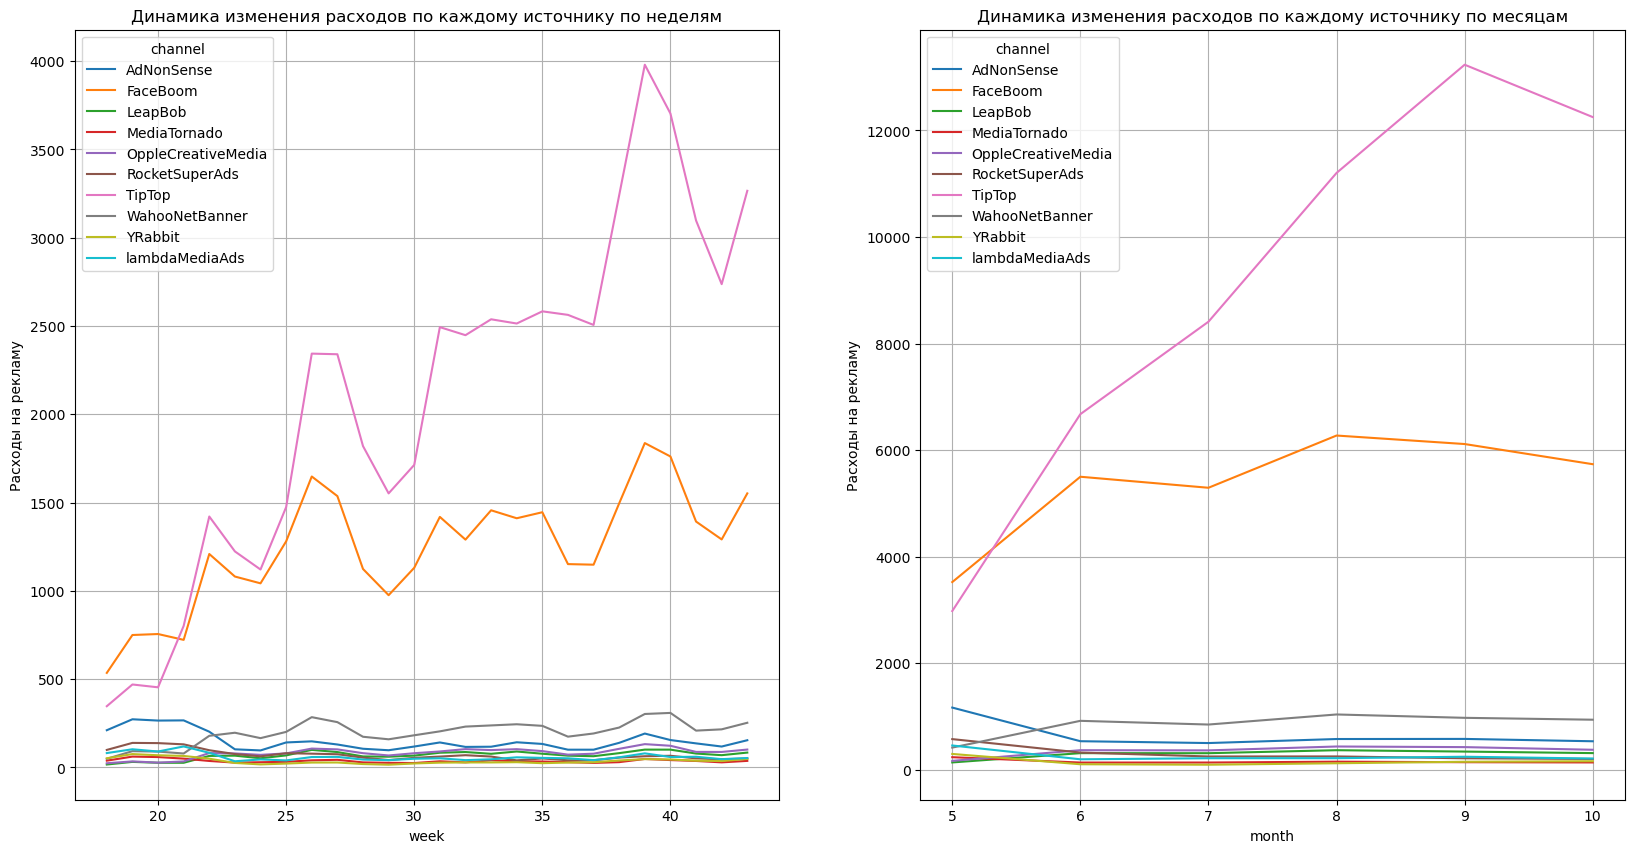

In [27]:
# задаем размер сетки для графиков
plt.figure(figsize=(20, 10))

for i, col in enumerate(['week', 'month']):
    
    # строим сводную таблицу и график  
    costs.pivot_table(
        index=col, columns='channel', values='costs', aggfunc='sum'
    ).plot(
        grid=True, 
        ax=plt.subplot(1, 2, i + 1), 
        ylabel='Расходы на рекламу'
    )
    
    # если col принимает значение 'week', то col примет новое значение - 'неделям'
    # иначе col примет новое значение - 'месяцам'
    if col == 'week':
        col = 'неделям'
    else:
        col = 'месяцам'
    
    plt.title('Динамика изменения расходов по каждому источнику по {}'.format(col));

По графикам можно наблюдать рост расходов в течение всего периода на те самые рекламные источники - TipTop и FaceBoom. Расходы  на остальные источники привлечения стабильны и достаточно низки.

<a id="cac"></a>

### Средняя стоимость привлечения одного пользователя (CAC) из каждого источника 

Посчитаем средний CAC по каналам привлечения.

In [28]:
# сгруппируем данные по каналам привлечения и посчитаем средний CAC по каждому источнику
cac = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False) 

# переименуем столбец
cac.columns = ['cac']
cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Самым дорогим источником привлечения пользователей является TipTop. Средняя стоимость привлечения одного пользователя обходится компании в 2.8 долларов. Следующими по затратам на одного пользователя являются FaceBoom и AdNonSense - 1.1 долл. и 1 долл. соответственно.

**Вывод**

<div class="alert alert-info">   

* Всего расходы на рекламу составили 105,5 тысяч долларов за полгода. Причем половина всего бюджета была направлена на лишь на один рекламный источник *TipTop* - **51.90%**, а **30.75%** затрат ушло на канал *FaceBoom*.
* Также по графику динамики в течение всего периода наблюдается рост инвестиций в эти же источники, хотя расходы на остальные 8 каналов привлечения стабильно низки.
* Средняя стоимость привлечения одного пользователя на канале *TipTop* обходится компании в **2.8** долларов, что более, чем в  2,5 раза больше средней стоимости привлечения одного пользователя на канале *FaceBoom* - **1.11** долл и *AdNonSense* - **1** долл, которые стоят в 3-ке лидеров по высокой стоимости привлечения одного пользователя.
     </div>

<a id="eva"></a>

## Оценка окупаемости рекламы


<a id="ad"></a>

### Общая окупаемость рекламы  

Оценим общую ситуацию — посмотрим на окупаемость рекламы.   
Если считать, что на календаре 1 ноября 2019 год, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, то установим, что момент анализа 1.11.2019, а горизонт анализа 14 дней.

In [29]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа

Исключим из анализа пользователей, которые достаются компании бесплатно, т.е. органических пользователей.

In [30]:
# исключим из данных 'organic'
profiles = profiles.query('channel != "organic"')

Рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`.

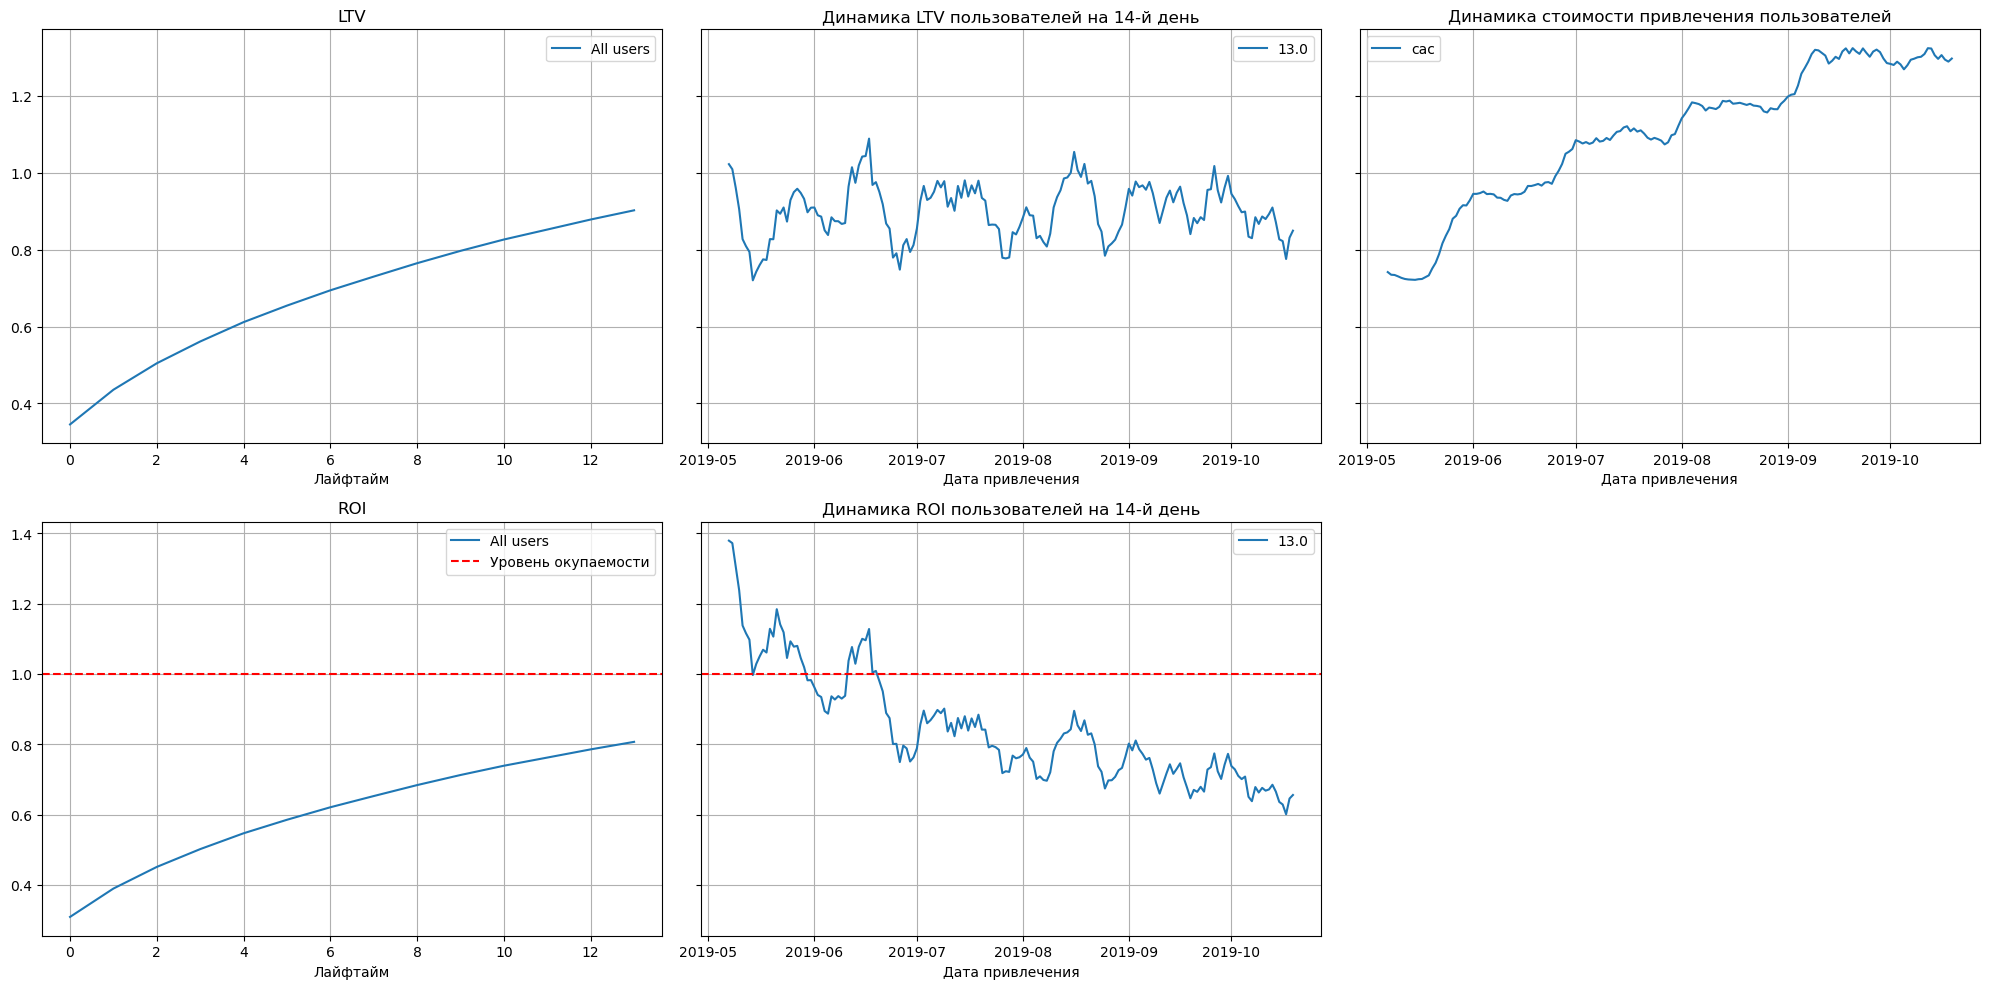

In [31]:
# посчитаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Выводы, которые можно сделать по графикам:  

* Реклама не окупается, поскольку ROI в конце второй недели — чуть выше 80%, что протеворечит  бизнес-плану. Динамика ROI показывает, что реклама вовсе перестала окупаться ближе к концу июня.
* Динамика LTV достаточно стабилена. Значит, дело не в ухудшении качества пользователей.
* А вот динамика CAC постоянно растет, что говорит о росте расходов на привлечение клиентов

<a id="device"></a>

### Окупаемость рекламы с разбивкой по устройствам  

Проанализируем показатели LTV, CAC и ROI с разбивкой по различным критериям — устройству, стране и источнику первого посещения.  
Начнём с разбивки по устройству: передадим параметру `dimensions` столбец `device`.

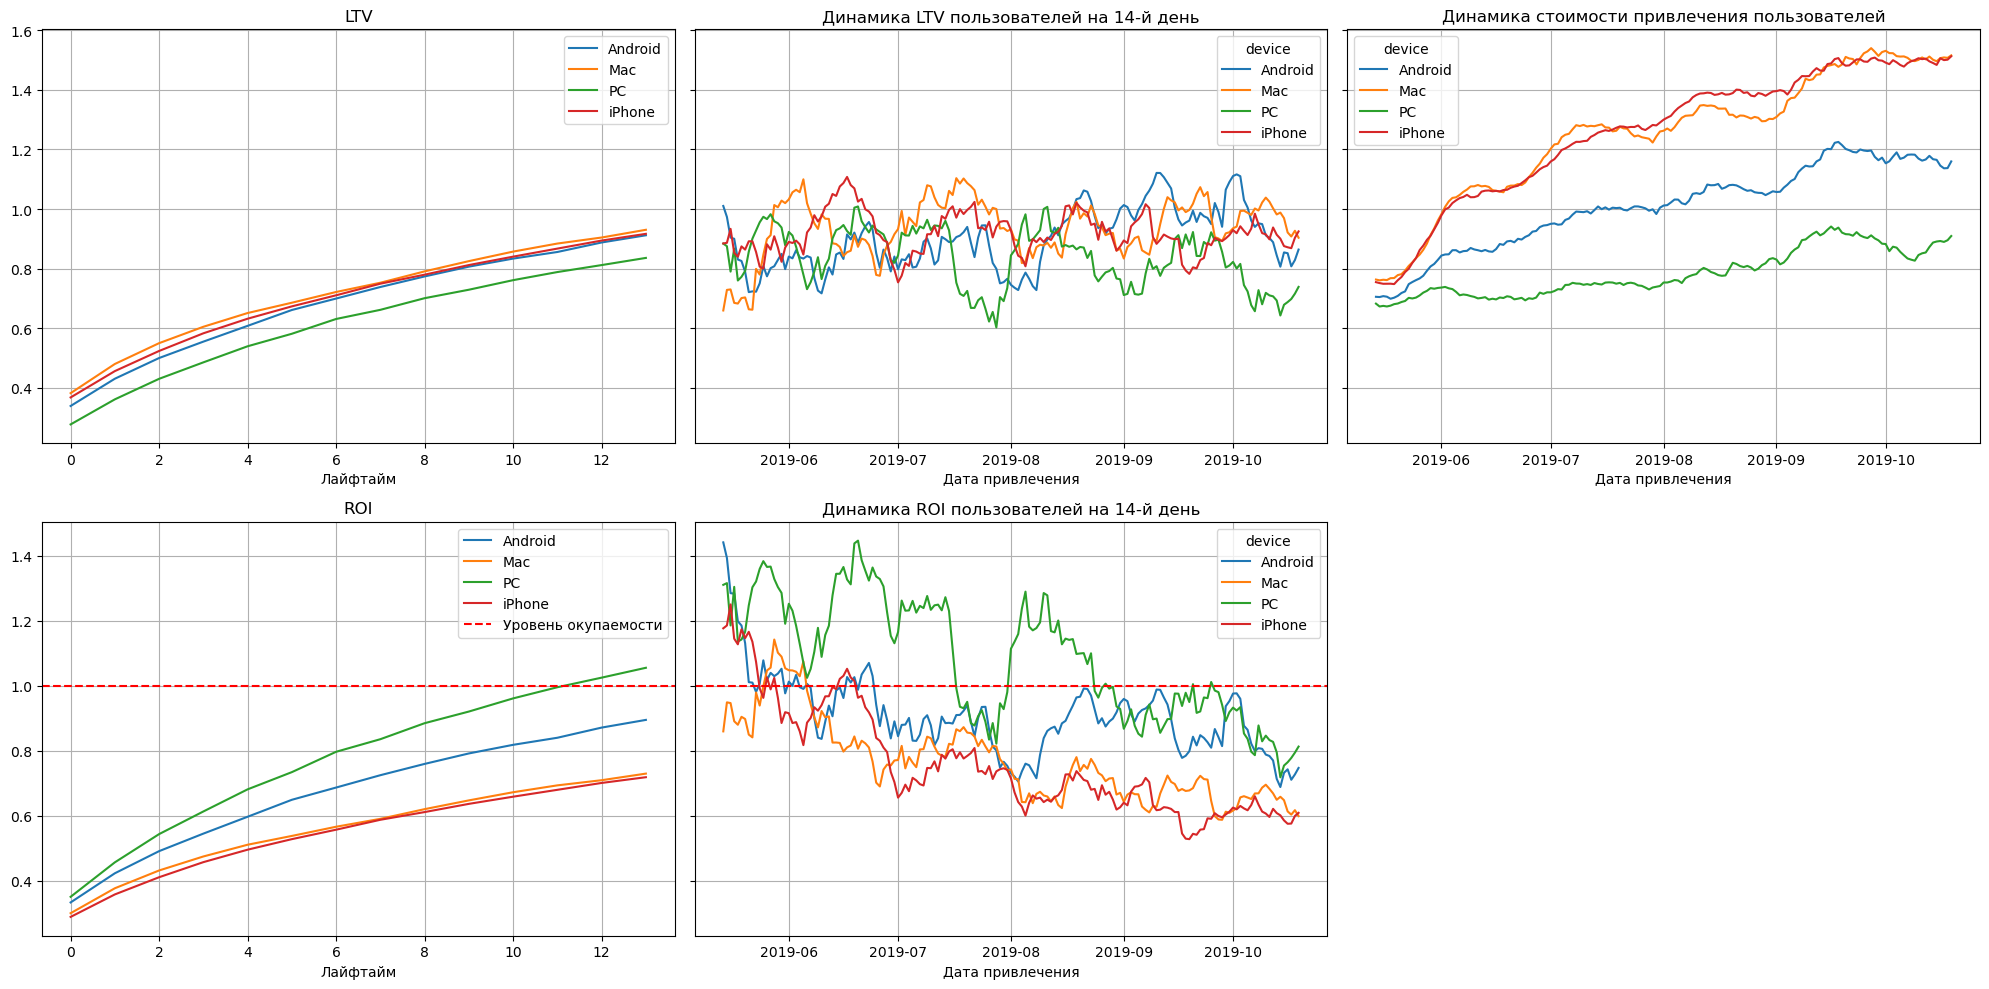

In [32]:
# построим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выводы, которые можно сделать по графикам:  

* Реклама не окупается, только пользователи PC переходят порог окупаемости лишь на 12 день. Динамика ROI показывает, что реклама вовсе перестала окупаться и для пользователи PC, начиная с сентября. Самыми не окупаемыми являются владельцы устройств iPhone и Mac.
* Динамика LTV достаточно стабилена на всех девайсах. Значит, дело не в ухудшении качества пользователей.
* Динамика стоимости привлечения пользователей (CAC) постоянно растет на всех платформах, особенно на iPhone и Mac.

Проверим конверсию с разбивкой по устройствам.

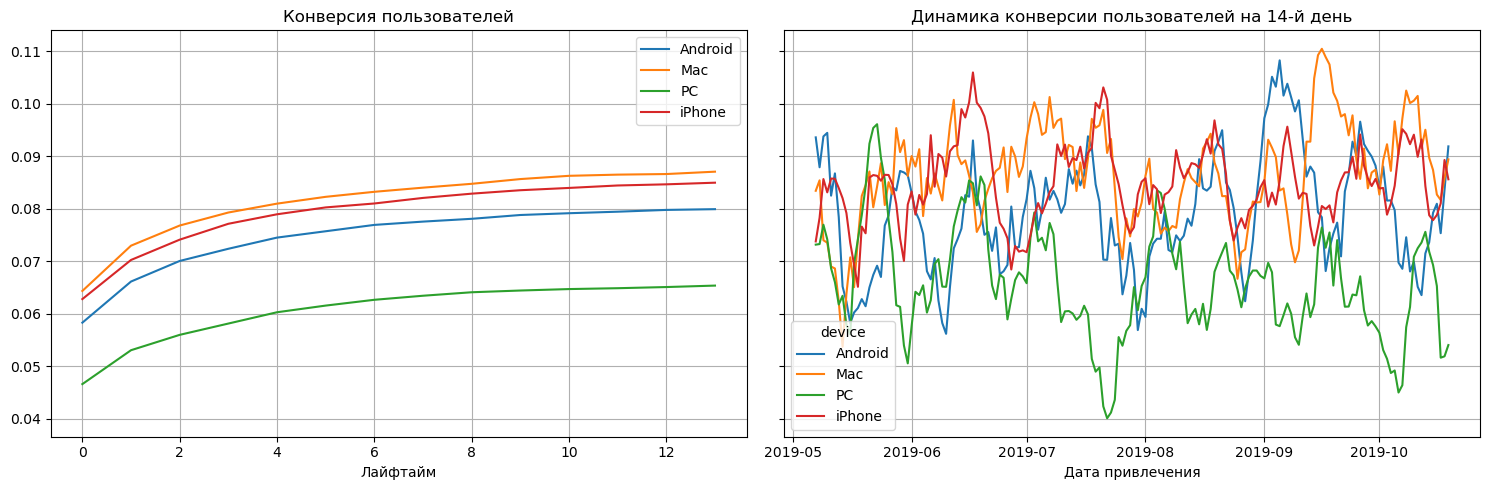

In [33]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Несмотря на то, что окупаемость рекламы для пользователей PC выше всего, пользователи iPhone, Mac и Android конвертируются лучше, чем пользователи PC.  

Посмотрим на удержание с разбивкой по устройствам. Вызовем функции `get_retention()` и `plot_retention()` для подсчета и построения графиков удержания.

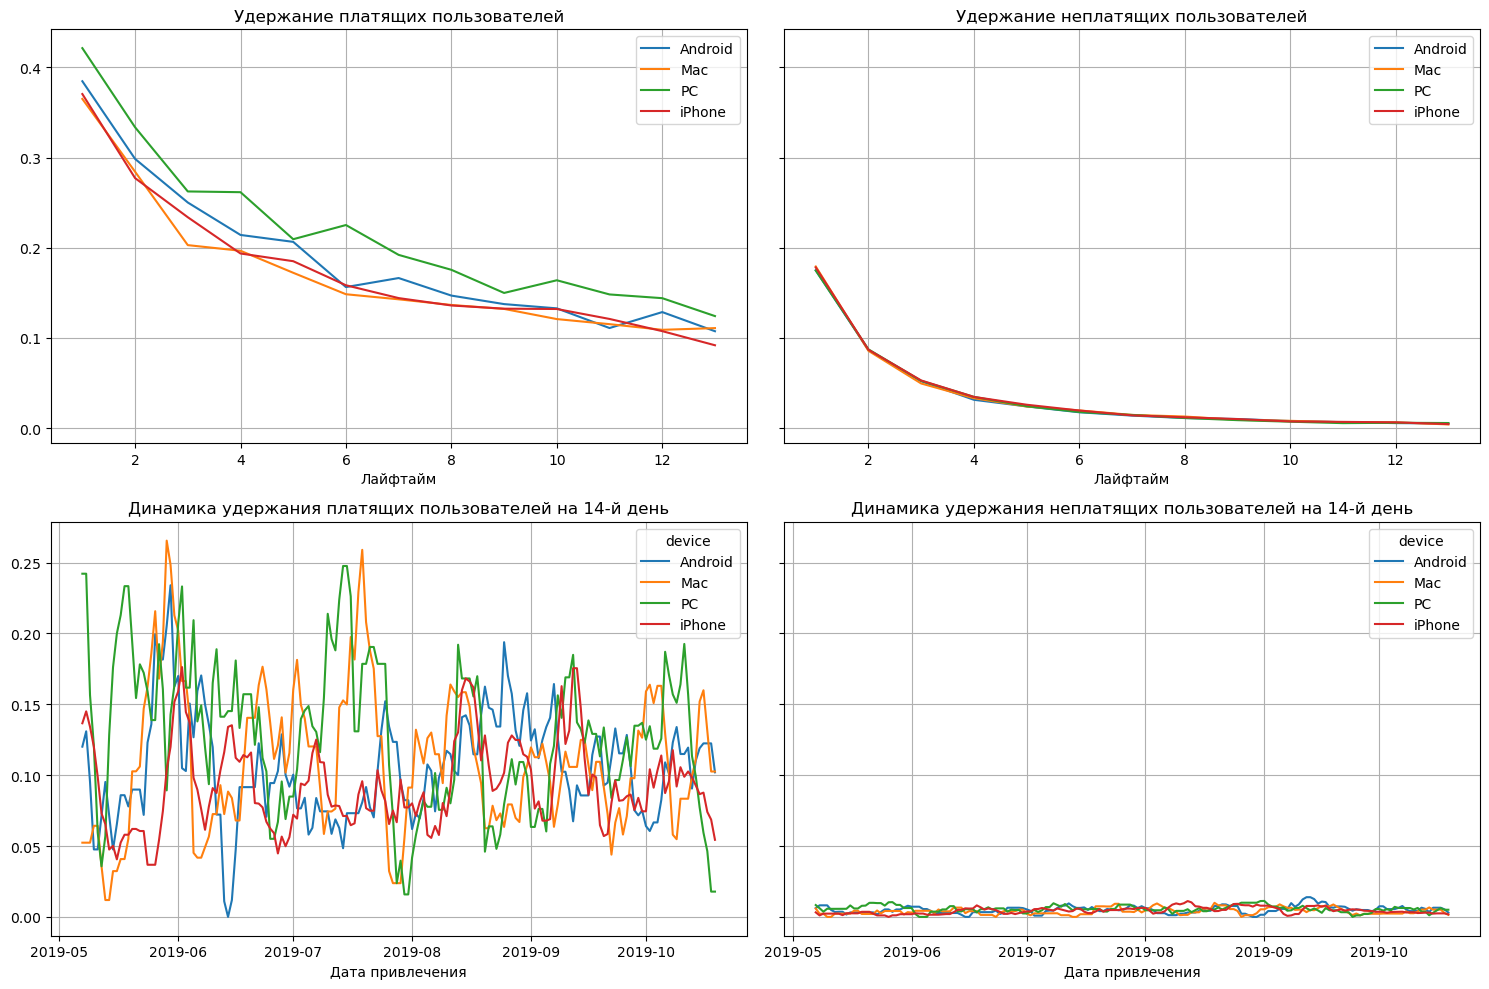

In [34]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

In [35]:
retention_grouped

cohort_size    0         1         2         3         4  \
payer device                                                              
False Android        18988  1.0  0.174953  0.086476  0.051928  0.031336   
      Mac            16150  1.0  0.179195  0.085635  0.049412  0.033065   
      PC             16920  1.0  0.174704  0.087234  0.052364  0.034574   
      iPhone         29276  1.0  0.178098  0.086829  0.052774  0.034533   
True  Android         1695  1.0  0.384661  0.298525  0.250147  0.214159   
      Mac             1597  1.0  0.365059  0.284283  0.202880  0.196619   
      PC              1208  1.0  0.421358  0.333609  0.262417  0.261589   
      iPhone          2810  1.0  0.370463  0.277224  0.233808  0.193594   

                      5         6         7         8         9        10  \
payer device                                                                
False Android  0.024015  0.017485  0.013798  0.011060  0.010006  0.007742   
      Mac      0.023901  0.019505  0.014551  0.012755  0.009102  0.007988   
      PC       0.024232  0.017790  0.014539  0.011170  0.008747  0.007033   
      iPhone   0.025857  0.019436  0.014039  0.011921  0.009940  0.007310   
True  Android  0.206490  0.156342  0.166372  0.146903  0.137463  0.132743   
      Mac      0.172198  0.148403  0.142768  0.136506  0.132123  0.120852   
      PC       0.209437  0.225166  0.192053  0.175497  0.149834  0.163907   
      iPhone   0.185053  0.158363  0.144128  0.135943  0.132384  0.132028   

                     11        12        13  
payer device                                 
False Android  0.006530  0.005477  0.005056  
      Mac      0.006440  0.006254  0.004025  
      PC       0.005437  0.005851  0.005556  
      iPhone   0.006832  0.006319  0.004372  
True  Android  0.110914  0.128614  0.107375  
      Mac      0.115216  0.108954  0.110833  
      PC       0.148179  0.144040  0.124172  
      iPhone   0.120996  0.107473  0.091815

Показатель удержания практически одинаковы для всех пользователей на любых платформах. Поэтому не похоже, что причина плохой окупаемости скрывается в виде девайса.

<a id="country"></a>

### Окупаемость рекламы с разбивкой по странам  
  
Посмотрим на окупаемость с разбивкой по странам, поэтому передадим параметру `dimensions` столбец `region`.

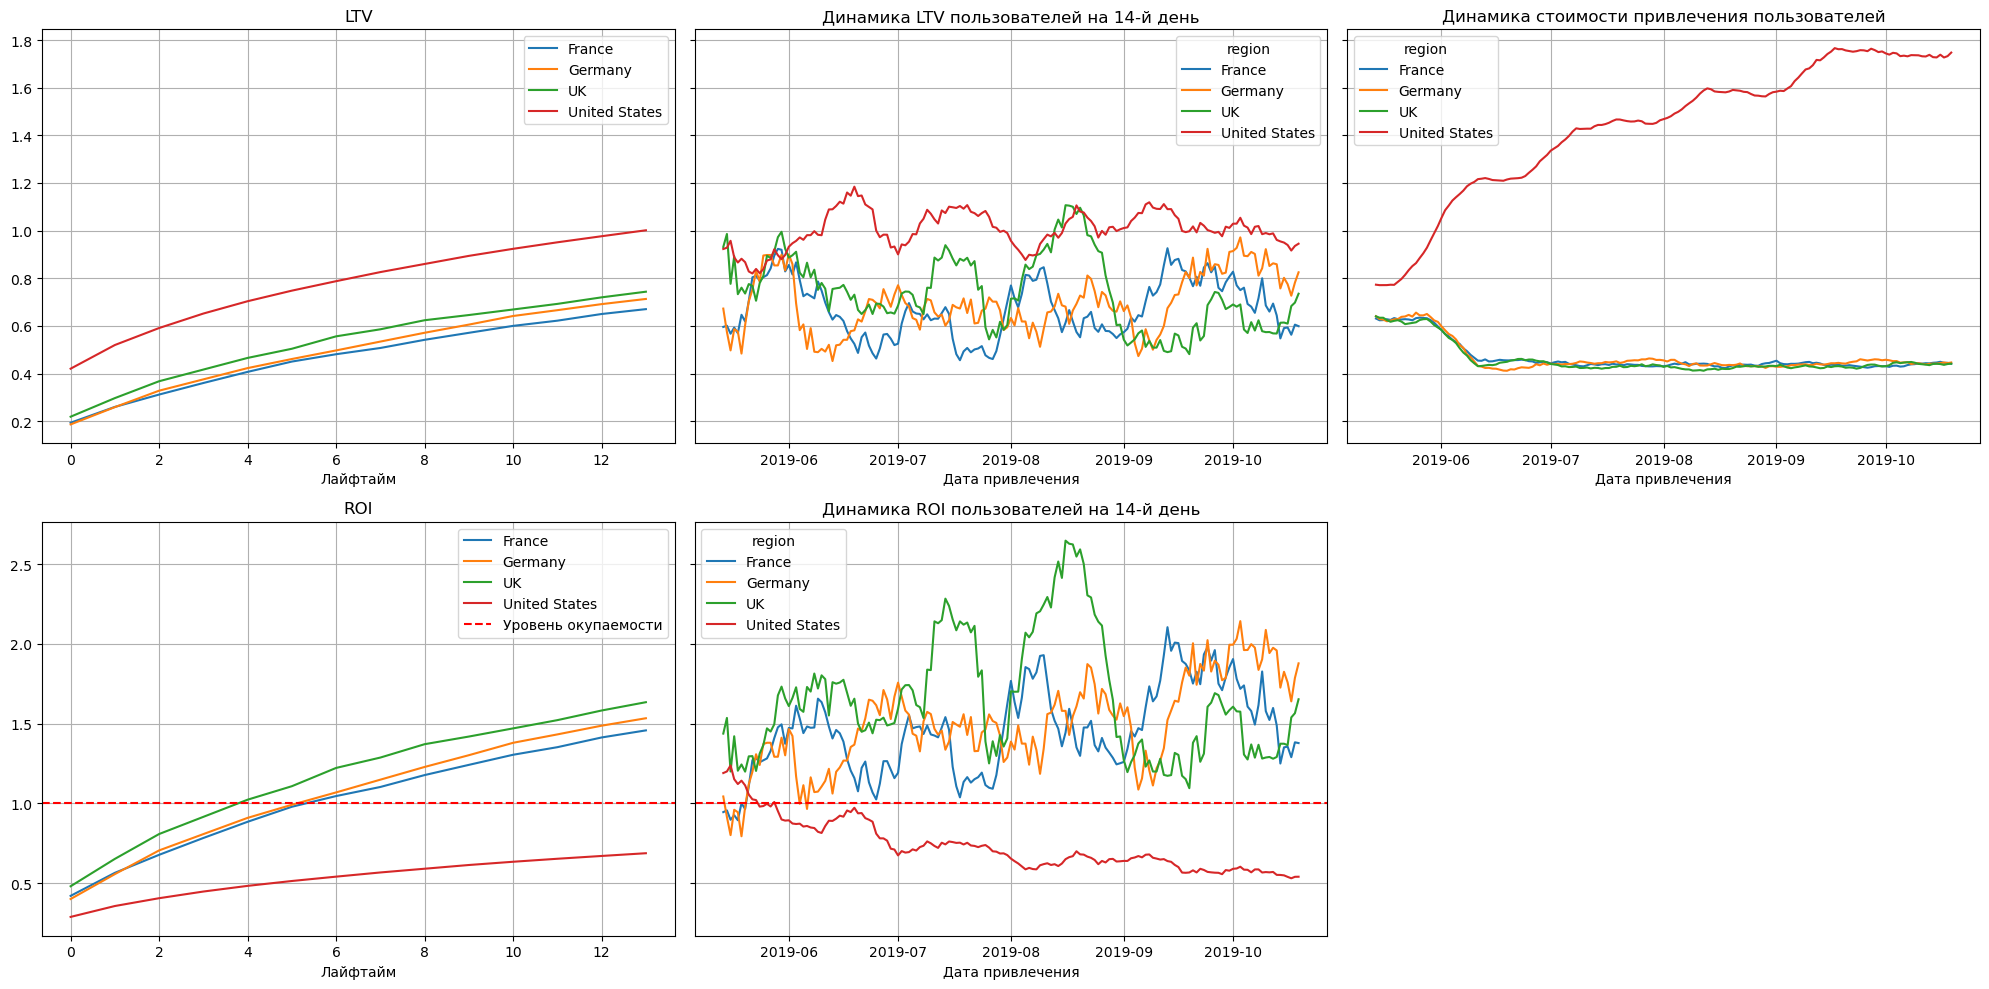

In [36]:
# построим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Выводы, которые можно сделать по графикам:  

* Динамика LTV достаточно стабилена, но LTV пользователей из США выше всех. 
* При этом динамика CAC у США постоянно растет и на конец второй недели на 1 доллар прибыли с одного пользователя приходится в среднем 1,7-1,8 долл расходов на его привлечение.
* Реклама окупается только с пользователей стран Европы на 5-6 день, США же совсем не достигает порога окупаемости. Динамика ROI показывает, что у США уровень окупаемоти к концу октября упал до 50-60%.


Проверим конверсию с разбивкой по странам.

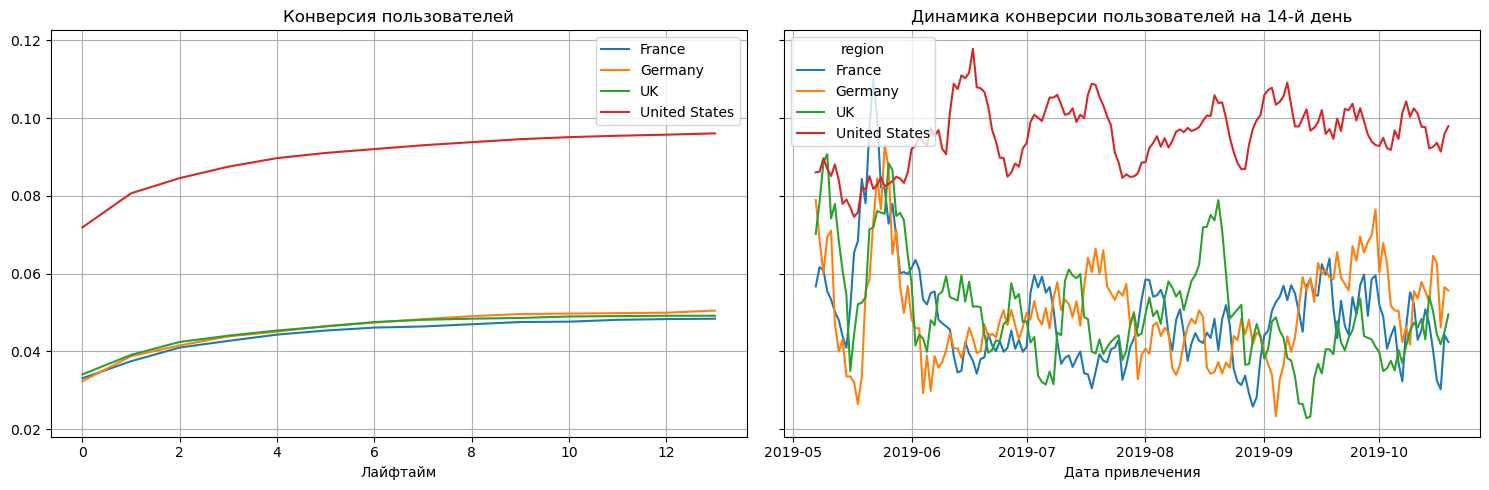

In [37]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи из США конвертируются лучше, чем пользователи из Европы. Динамика конверсии стабильна у всех стран.  
Проверим удержание пользователей с разбивкой по странам.

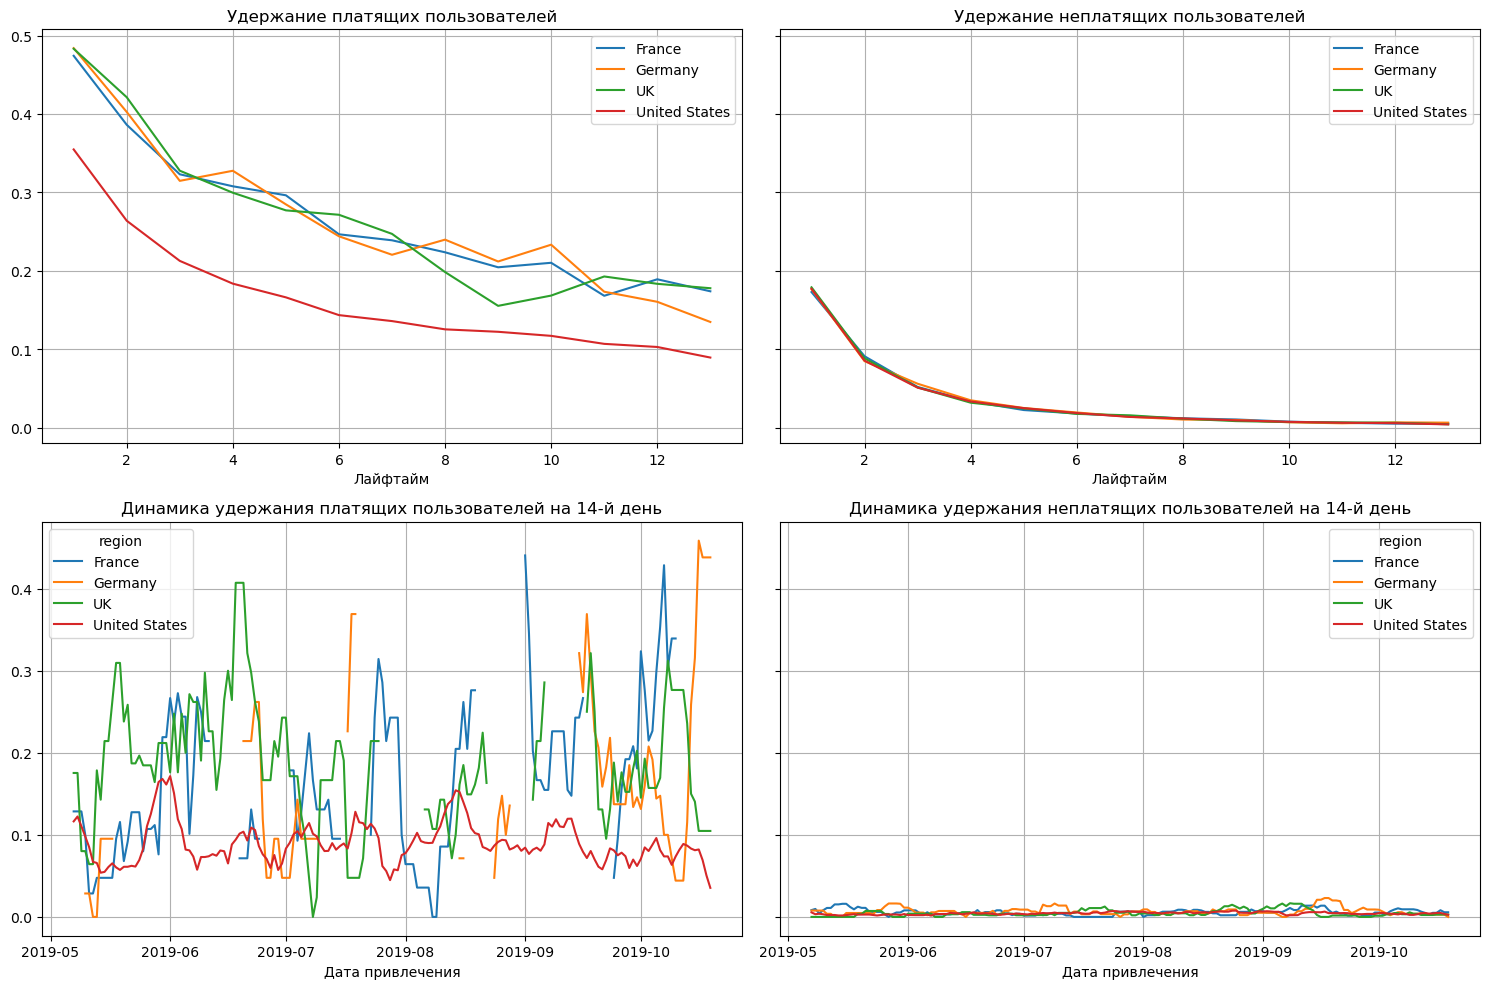

In [38]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Однако при высокой конверсии коэффициент удержания платящих пользователей для США самый низкий - много пользователей конвертируется и быстро уходят.  
На графике динамики удержания заметны разрывы линий стран Европы, возможно в какой-то день ни один пользователь не перешел в приложение, что вполне вероятно, судя по небольшому количеству пользователей из Европы.

<a id="channel"></a>

### Окупаемость рекламы с разбивкой по каналам привлечения 

Теперь передадим параметру `dimensions` столбец `channel`, чтобы выяснить влияние рекламных источников.

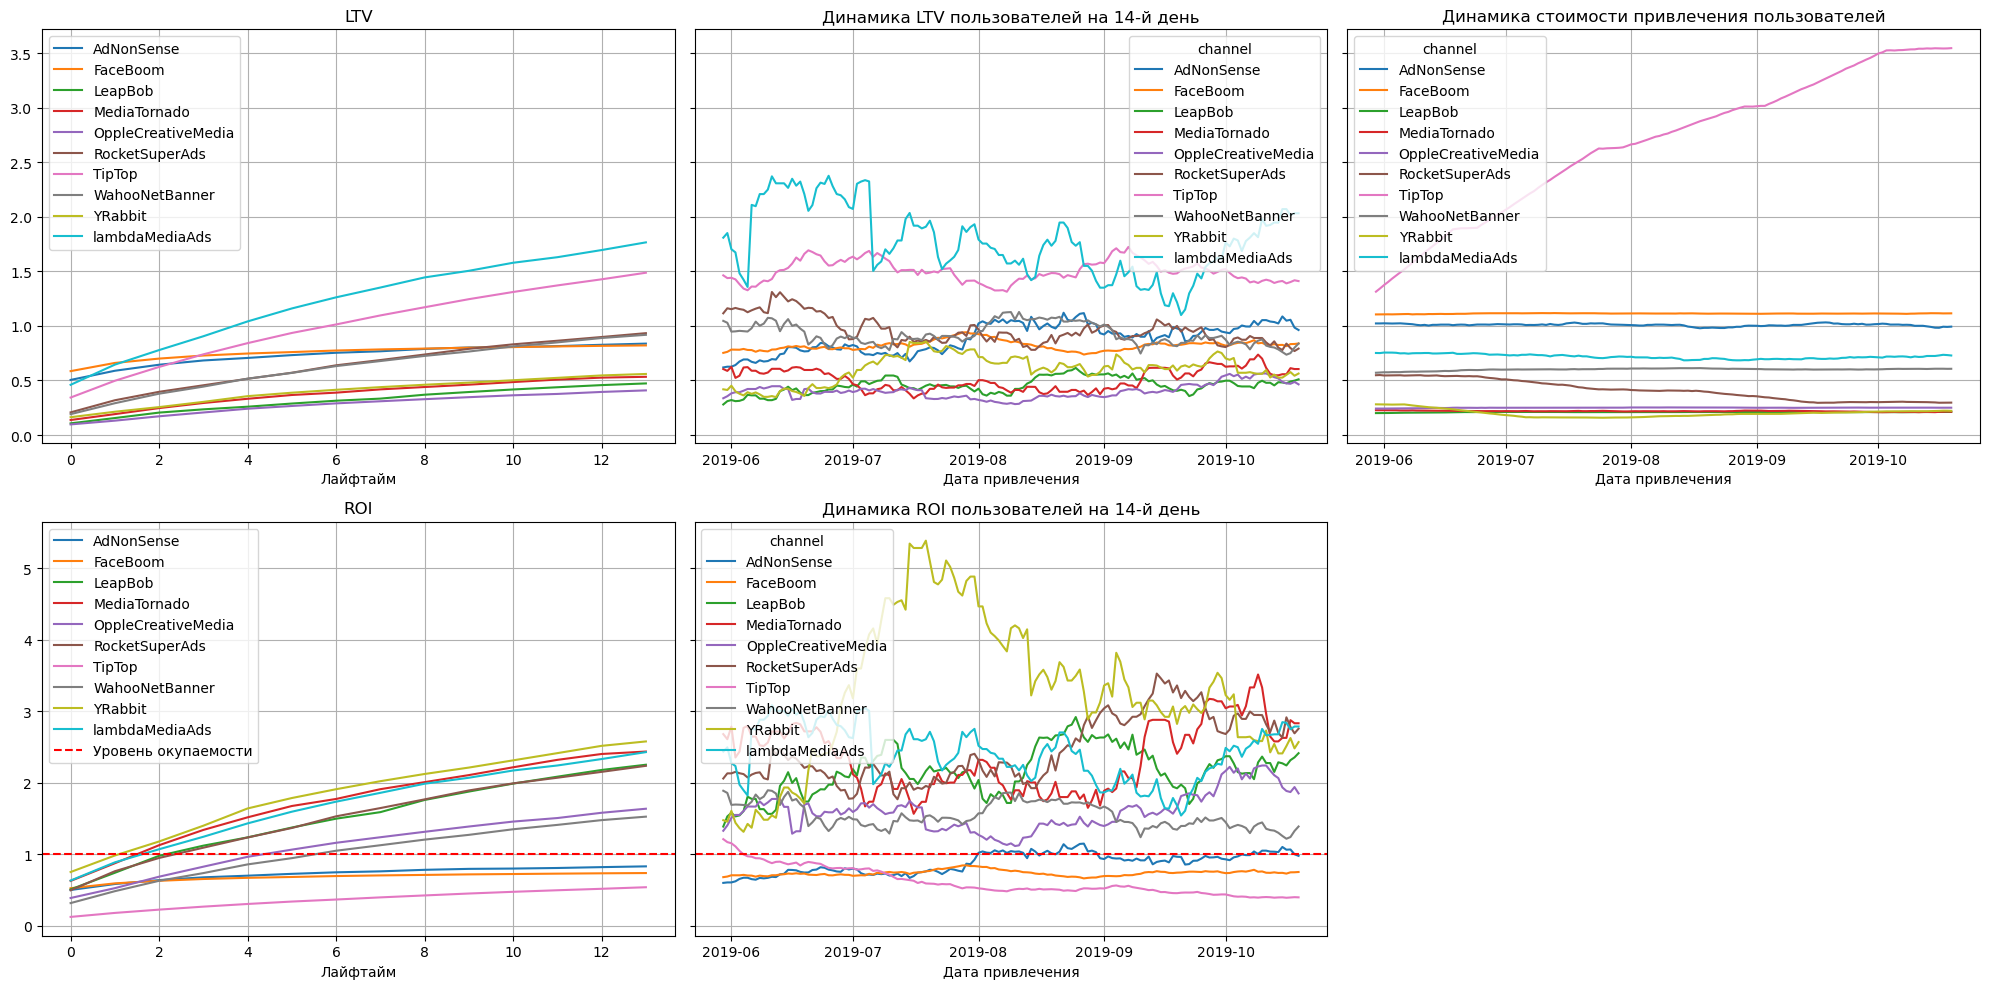

In [39]:
# построим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=30
) 

Выводы, которые можно сделать по графикам:  

* Динамика LTV говорит о стабильном качестве пользователей, но LTV пользователей, перешедших с канала lambdaMediaAds и TipTop, выше всех. 
* Также динамика CAC постоянно растет у источника TipTop, стоимость привлечения пользователей у других источников стабильна.
* Реклама окупается со всех рекламных источников, кроме TipTop, FaceBoom и AdNonSense.

Поскольку из всех старн только США не окупается, посмотрим какие каналы принадлежат США, а какие странам Европы.

In [40]:
# сгруппируем по каналам привлечения и выведем их регион
profiles.groupby('channel').agg({'region': 'first'}).sort_values('region')

,region
channel,
OppleCreativeMedia,France
AdNonSense,Germany
LeapBob,Germany
WahooNetBanner,UK
lambdaMediaAds,UK
FaceBoom,United States
MediaTornado,United States
RocketSuperAds,United States
TipTop,United States


Сделаем более подробный вывод.  
* Американские пользователи, перешедшие в приложение с каналов TipTop и FaceBoom, не окупаются. Источник TipTop даже с самой высоким и стабильным LTV не окупается из-за роста и слишком высокой стоимости привлечения пользователя.   
* А у FaceBoom с умеренным и стабильным LTV, не наблюдается роста стоимости на привлечение пользователя, но при этом CAC все равно слишком высокий, чтобы реклама окупилась. 
* Германский канал AdNonSense также как и FaceBoom не окупается в связи с высокой стоимостью привлечения пользователя.

Проверим конверсию с разбивкой по рекламным источникам.

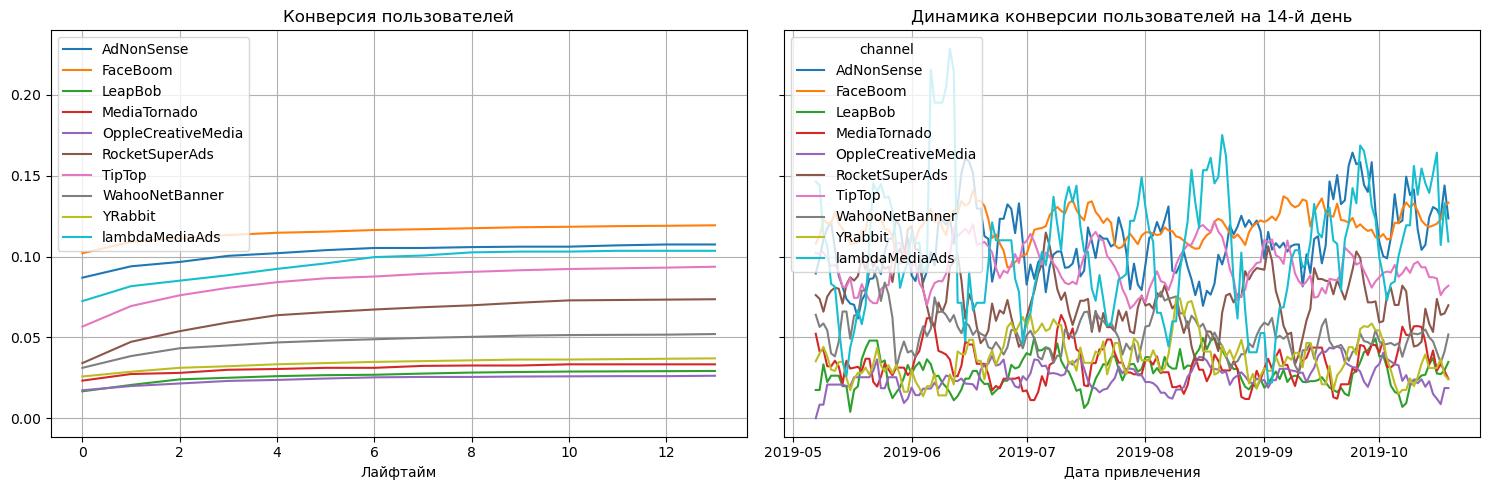

In [41]:
# смотрим конверсию с разбивкой по источникам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, лучше всего конвертируются пользователи, которые пришли из FaceBoom, а также AdNonSense, lambdaMediaAds и TipTop. Также в динамике можно увидеть рост у каналов AdNonSense, FaceBoom и lambdaMediaAds.

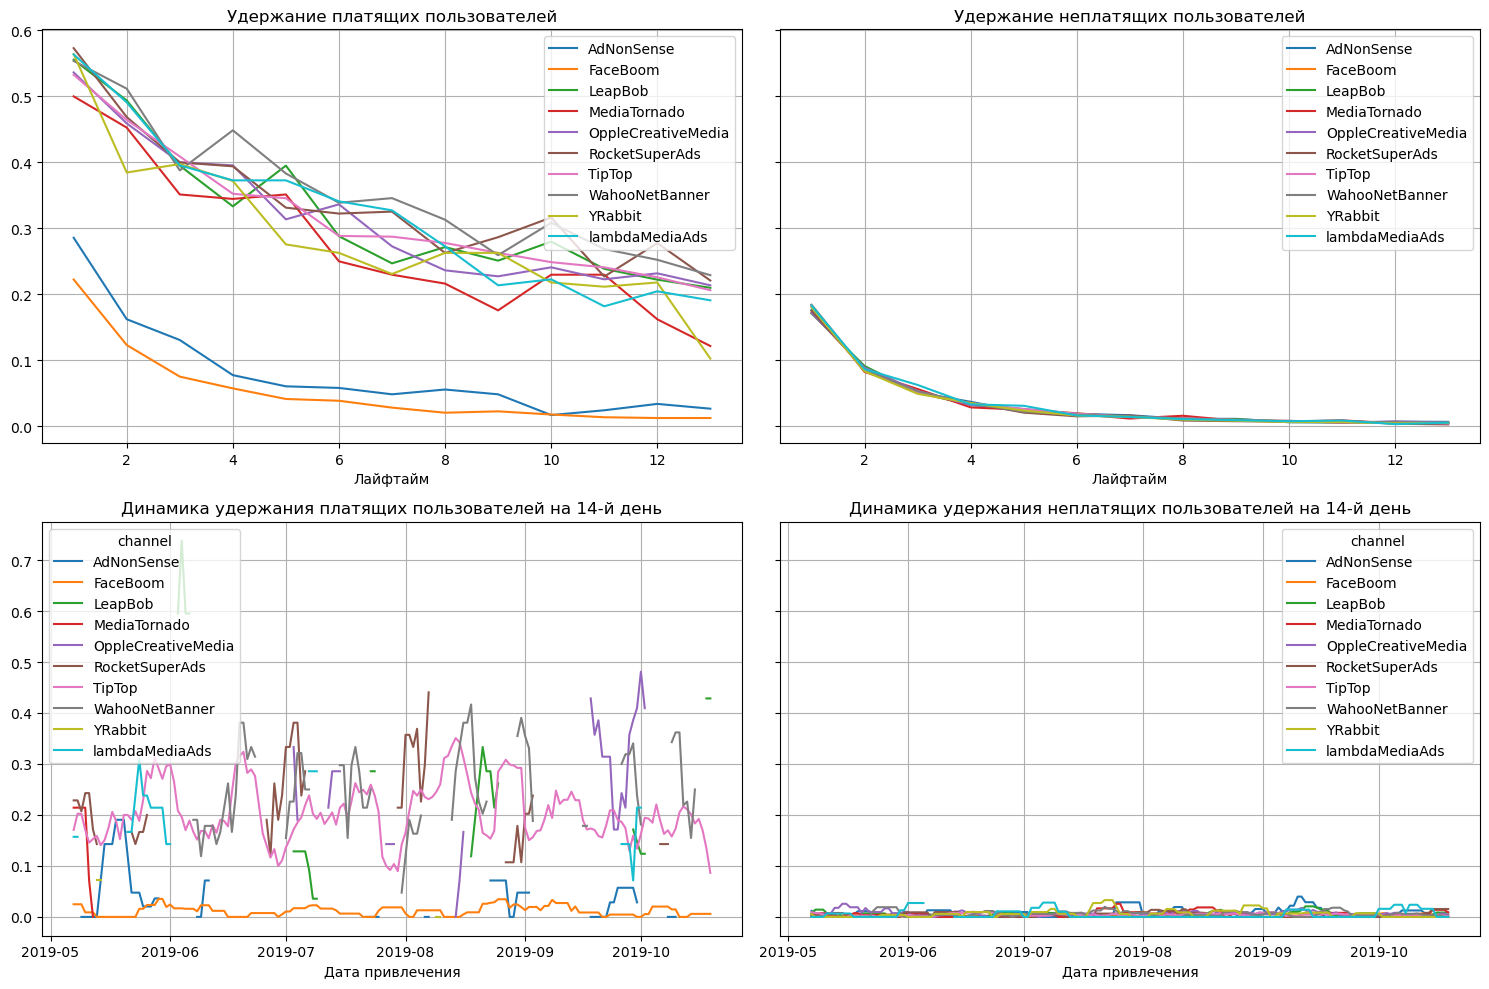

In [42]:
# смотрим удержание с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Самый низкий коэффициент удержания наблюдается у платящих пользователей, которые пришли из FaceBoom и AdNonSense, при этом у этих источников самая высокая конверсия.

**Выводы**

<div class="alert alert-info">  
    
* При анализе общей "картины" мы выяснили, что LTV стабилен, чего не скажешь о CAC. Поскольку стоимость привличения пользователя постоянно растет, а прибыль с одного клиента постоянна и не увеличивается, окупаемости рекламы не происходит. К концу июня реклама перестала окупаться, ROI достиг к концу второй недели только 80%, когда предельный уровень окупаемости составляет 100%.
    
    
* При оценке окупаемости рекламы с разбивкой по устройствам установили, что пользователи всех девайсов не окупаются. Самые неокупаемыми являются iPhone и Mac, т.е.устройства с системами IOS, что говорит скорее о популярности фирмы Apple в США. Поэтому неокупаемость рекламы не связа с устройстом пользователя. 
    
    
* Поскольку при оценке окупаемости рекламы с разбивкой по странам обнаружили, что из всех стран не окупается только пользователи США. Хотя у них больше LTV и конверсия, у них также постоянно растущие расходы на рекламу и меньший коэффициент удержания платящих пользователей. А при том, что количество пользователей из США больше половины от всей массы, расходы на их привлечение превышают общую прибыль от стран Европы, а значит это и влияет на общую окупаемость.  
    
    
* При исследовании окупаемости рекламы с разбивкой по каналам привлечения установили, что только 2 канала привлечения из 5 не окупаются в США - TipTop и FaceBoom и 1 из 5 - в Европе - AdNonSense.   
    Поскольку у источника TipTop даже с самой высоким и стабильным LTV постоянно растет стоимость привлечения пользователя и достигает 3.5 долл при прибыли от покупателя 1,5 долл. Именно в этот источник было вложено половина рекламного бюджета.  Вероятнее всего это источник привлечения является слишком дорогим.  
    Хоть у источников FaceBoom и AdNonSense стабильный CAC, он все равно слишком высокий. Также у даннных каналов хорошая конверсия, но достаточно низкий коэффициент удержания платящих пользователей. Это может быть связано с нецелевой аудиторией. Однако европейский канал AdNonSense не повлиял на окупаемость рекламы в Европе, а конкретно в Германии в отличии от американского источника привлечения.
    
</div>
     

<a id="rec"></a>

## Общий вывод и рекомендации

<div class="alert alert-info">   
    
Мы изучили данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

**1. Была изучена информация о трех датасетах.**
    
- Файл, содержащий лог сервера с информацией о посещениях сайта, имеет всего 309901 запись и 6 столбцов
- Файл, содержащий лог сервера с информацией о заказах, имеет всего 40212 запись и 3 столбца.  
- Файл, содержащий лог сервера с информацией о тратах на рекламу, имеет всего 1800 запись и 3 столбца.
    
   В результате были обнаружены:
    
* Некорректные наименования столбцов - используется верхний регистр и отсутствует стиль snake case
* Некорректный тип данных в столбцах с времнем
* Пропуски не обнаружены
   
    В разделе предобратоки данных были:
    
* переведены все наименования столбцов в нижний регистр и переименованы с соблюдением стиля;  
* не было обнаружено явных строк-дублиикатов;  
* изменили тип данных в `session_start`, `session_end`, `event_dt`, `dt` на datetime. Столбец `dt` был переведен обратно для дальнейшей с ним работы.
    
Процент потери данных после предобработки данных составил **0%**.
    
**2. В разделе "Функции для расчёта и анализа LTV, ROI, удержания и конверсии":**

Написали функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

**3. Провели исследовательский анализ**
  
* Составили профили пользователей и определили их минимальную и максимальную даты привлечения - **с 2019-05-1 до 2019-10-27.**
    
* **Анализ распределения пользователей с разбивкой по странам**: пользователи приходят в приложение из США, Украины, Франции и Германии. Большая часть пользователей, как и платящих, приходят из США - более половины всех пользователей.  
    Доля платящих:
    - США - **6.90%**
    - Германия - **4.11%**
    - Украина - **3.98%**
    - Франция - **3.80%**
    
* **Анализ распределения пользователей с разбивкой по каналам привлечения**: наибольшую популярность у пользователей занимает iPhone, но по доле платящих он уступает устройству Mac.
    Доля платящих:
    - Mac - **6.36%**
    - iPhone - **6.21%**
    - Android - **5.85%**
    - PC - **5.05%**
   
* **Анализ распределения пользователей с разбивкой по каналам привлечения**: всего приложение имеет 10 источников привлечения, не считая "органических" пользователей. Самыми крупными каналами являются FaceBoom (29 тыс) и TipTop (19,5 тыс). Наименьшей известностью пользуются источники - AdNonSense (3,9 тыс) и lambdaMediaAds (2 тыс).  
    Однако в 4-ку лидеров по доле платящих входят: 
    - FaceBoom - **12.2%**
    - AdNonSense - **11.34%**
    - lambdaMediaAds - **10.47%**
    - TipTop - **9.6%**
    
**4. В разделе Маркетинг провели анализ расходов на рекламу**

* Посчитали общую сумму расходов на маркетинг - 105, 5 тыс.  
    Построили таблицу распределения расходов на привлечение пользователей по рекламным источникам и обнаружили, что на канал TipTop уходит **51,9 %** и на FaceBoom - **30,75 %**, когда на остальные источники от 0,9 % до 4,88%.  
* Построили графики динамики изменения расходов по каждому источнику по неделям и месяцам, по которым можно сделать вывод о больших расходах на рекламные источники - TipTop и FaceBoom в течение всего периода.
* Посчитали среднюю стоимость привлечения одного пользователя (CAC) из каждого источника. 
    Тройку лидеров по высокой стоимости привлечения клиентов вошли каналы:
    - TipTop - **2.8 долл**
    - FaceBoom - **1.1 долл**
    - AdNonSense - **1 долл**

**5. Оценили окупаемость рекламы**
    
*  При анализе общей окупаемости рекламы мы выяснили, что LTV стабилен, чего не скажешь о CAC. Поскольку стоимость привличения пользователя постоянно растет, а прибыль с одного клиента постоянна и не увеличивается, окупаемости рекламы не происходит. К концу июня реклама перестала окупаться, ROI достиг к концу второй недели только 80%, когда предельный уровень окупаемости составляет 100%.
* **Окупаемость рекламы с разбивкой по устройствам:** пользователи всех девайсов не окупаются, особенно устройства с системами IOS, что говорит скорее о популярности фирмы Apple в США и о уже изветном подовляющим количестве американских пользователей. Конверсия лучше у пользователей iPhone, Mac и Android, чем у пользователей PC, но удержание практически для всех одинаковое. Поэтому причины неокупаемости рекламы скорее всего не связаны с устройстом пользователя.
* **Окупаемость рекламы с разбивкой по странам:** анализ показал, что из всех стран не окупаются только пользователи США. Показатель LTV в США выше, чем в других регионах, и составляет на конец второй недели около 1 доллара, но динамика CAC показывает большой рост, поэтому увеличение расходов на привлечение одного пользователя превосходит прибыль от этого пользователя и уже в октябре на его привлечение приходится в среднем 1,7-1,8 долл. Конверсия в США тоже выше, а коэффициент удержания платящих пользователей самый низкий, что говорит о качестве пользователей и о быстрой их потери. Поскольку количество пользователей из США больше половины от всей массы, расходы на их привлечение превышают общую прибыль от стран Европы, а значит это и влияет на общую окупаемость.
* **Окупаемость рекламы с разбивкой по каналам привлечения:** при исследовании окупаемости рекламы с разбивкой по каналам привлечения выяснили, что американские источники TipTop и FaceBoom являются самыми невыгодными каналами привлечения: 
    - в источник **TipTop** было вложено половина рекламного бюджета. TipTop имеет почти самый высокий и стабильный LTV, который на конец второй недели составляет 1,5 долл, также у него хорошая конверсия и удержание платящих пользователей. Однако динамика CAC показывает огромные расходы на привлечения одного пользователя, которые превышают доходы с него, и достигают в октябре уже 3.5 долл. 
    - **FaceBoom** имеет самую стабильную стоимость на привлечение одного пользователя CAC на протяжении всего периода и составляет около 1,1-1,2 долл, но показатель LTV варьируется от 0,5 до 0,8 долл, т.е. доходы не превышают расходов на привлечение одного пользователя. Также у FaceBoom самая высокая конверсия и самый низкий коэффициент удержания платящих - пользователи приходят и быстро уходят, не успев выйти на точку безубыточности. Это может быть связано с нецелевой аудиторией.  

У канала **AdNonSense** аналогичная ситуация с FaceBoom, но европейский канал не повлиял на окупаемость рекламы в Европе, а конкретно в Германии в отличии от американского источника привлечения.    
    
    
**Краткий итог:**
В результате, причинами убытков приложения Procrastinate Pro+ за последние несколько месяцев являются два источника привлечения пользователей - **TipTop** и **FaceBoom**, а точнее направленные в них инвестиции, которые настолько не окупаются, что влияют на всю выручку в  целом.
    
**Рекомендации:**  

* Перераспределить рекламный бюджет. Пересмотреть вложения в рекламные источники и обратить внимание на более выгодные каналы. Например, европейский канал lambdaMediaAds с самым высоким LTV, при этом с небольшой стоимостью привлечения клиента, высокой конверсией и хорошим удержаннием платящих клиентов. Также перспективными могут быть американские источники MediaTornado и YRabbit с самой лучшей окупаемостью и RocketSuperAds с самой высокой конверсией из них.
* Обратить на низкий уровень удержания платящих клиентов. Может быть это нецелевая аудитория. Иначе целевая аудитория, которая приходит с этого источника, либо не подходит продукт, либо получили плохой пользовательский опыт. Возможно следует улучшить продукт или посмотреть, на каком шаге взаимодействия с ним пользоватили отваливаются. Может проблема в соотношении цена/качество.
 

</div>